In [1]:
%load_ext tensorboard

In [ ]:
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras

from tqdm import tqdm
# from numba.cuda.cudadrv import enums
# from numba import cuda

2025-02-25 11:12:13.912485: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 11:12:14.080918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 11:12:14.080986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 11:12:14.100018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 11:12:14.141133: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import load_img


In [4]:
# gpu_options = tf.GPUOptions(visible_device_list="0")
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [5]:
# attribs= [name.replace("CU_DEVICE_ATTRIBUTE_", "") for name in dir(enums) if name.startswith("CU_DEVICE_ATTRIBUTE_")]
# for attr in attribs:
#     print(attr, '=', getattr(device, attr))

In [6]:
# # To split a folder containing dataset into train, valid, test folders
# # Just mention the folder containing sub folders each having a specific image related to folder
# # This would create train, val, test folders, each having same file structure

# caltech101_dir = "/home/abhinav/Documents/Work/2 Hobby_projects/Datasets/SLT/Static gestures of Indian Sign Language (ISL) for English Alphabet, Hindi Vowels and Numerals/ISL Images/2. Teenagers ISL Images/Teenagers ISL images in Half Sleeves/Total_data_half_sleeve"
# caltech101_out = "/home/abhinav/Documents/Work/2 Hobby_projects/Datasets/SLT/Static gestures of Indian Sign Language (ISL) for English Alphabet, Hindi Vowels and Numerals/ISL Images/2. Teenagers ISL Images/Teenagers ISL images in Half Sleeves/Total_data_half_sleeve/Train_data"

# import splitfolders
# splitfolders.ratio(caltech101_dir, output=caltech101_out, seed=1337, ratio=(.7, 0.2,0.1))   #Train, Valid, Test

In [7]:
# GPU settings



gpus = tf.config.list_physical_devices('GPU')



# Setting gpu[0] as main device
if gpus:
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


# Setting memory growth
try:
  tf.config.experimental.set_memory_growth(gpus[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass



# tf.debugging.set_log_device_placement(True)


os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

tf.debugging.set_log_device_placement(True)


1 Physical GPUs, 1 Logical GPU
cuda_malloc_async


2025-01-22 13:59:49.993499: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-22 13:59:50.032757: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-22 13:59:50.033392: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
train_dir = "/home/abhinav/Documents/Work/2 Hobby_projects/Datasets/SLT/Static gestures of Indian Sign Language (ISL) for English Alphabet, Hindi Vowels and Numerals/ISL Images/2. Teenagers ISL Images/Teenagers ISL images in Half Sleeves/Train_data/train"
valid_dir = "/home/abhinav/Documents/Work/2 Hobby_projects/Datasets/SLT/Static gestures of Indian Sign Language (ISL) for English Alphabet, Hindi Vowels and Numerals/ISL Images/2. Teenagers ISL Images/Teenagers ISL images in Half Sleeves/Train_data/val"
test_dir = "/home/abhinav/Documents/Work/2 Hobby_projects/Datasets/SLT/Static gestures of Indian Sign Language (ISL) for English Alphabet, Hindi Vowels and Numerals/ISL Images/2. Teenagers ISL Images/Teenagers ISL images in Half Sleeves/Train_data/test"

model_dir = "/home/abhinav/Documents/Work/2 Hobby_projects/Models"

In [9]:
input_shape = (150, 150, 3)
num_classes = 38
epochs = 7
batch_size = 16
Image_height = input_shape[0]
Image_width = input_shape[1]

dropout_rate = 0.1

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (Image_height, Image_width),
    color_mode="rgb",
    batch_size=batch_size,
    seed=1,
    shuffle=True,
    class_mode="categorical"
)

valid_datagen = ImageDataGenerator(
    rescale=1./255
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(Image_height, Image_width),
    color_mode="rgb",
    batch_size=batch_size,
    seed=7,
    shuffle=True,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(Image_height, Image_width),
    color_mode="rgb",
    batch_size=batch_size,
    seed=7,
    shuffle=True,
    class_mode="categorical"
)

train_num = train_generator.samples
valid_num = valid_generator.samples
train_num = train_generator.samples

Found 19070 images belonging to 38 classes.
Found 5441 images belonging to 38 classes.
Found 2757 images belonging to 38 classes.


In [11]:
model_LeNet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), padding="same", activation="tanh", input_shape=input_shape),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(16, (5, 5), activation='tanh'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(120, (5, 5), activation="tanh"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(84, activation='tanh'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_LeNet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
class MyNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(
            32,
            kernel_size=(3, 3),
            strides=1,
            padding="valid",
            kernel_initializer="he_normal",
            input_shape=input_shape,
            activation="relu"
        ))
        self.add(Dropout(dropout_rate))
        self.add(Conv2D(
            128,
            kernel_size=(3, 3),
            strides=2,
            padding="valid",
            kernel_initializer="he_normal",
            activation="relu"
        ))
        
        self.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=2,
            padding="valid",
            data_format=None
        ))
        self.add(Dropout(dropout_rate))
        self.add(Conv2D(
            256,
            kernel_size=(3, 3),
            strides=1,
            padding="valid",
            kernel_initializer="he_normal",
            activation="relu"
        ))

        self.add(Conv2D(
            256,
            kernel_size=(3, 3),
            strides=3,
            padding="valid",
            kernel_initializer="he_normal",
            activation="relu"
        ))
        self.add(Dropout(dropout_rate))
        # self.add(BatchNormalization(momentum=1))
        self.add(Flatten())
        # self.add(Dropout(0.5))
        # self.add(Dense(4096, activation="relu"))
        self.add(Dropout(0.4))
        # self.add(Dense(3796, activation="relu"))
        self.add(Dense(1000, activation="relu"))
        self.add(Dense(num_classes, activation="softmax"))

        self.compile(
            # optimizer=Ranger(learning_rate=0.0001),
            # optimizer=Ranger(learning_rate=0.000001, amsgrad=True, slow_step_size=0.8, warmup_proportion=0.3),
            optimizer=Adam(learning_rate=0.0001, use_ema=True, ema_momentum=1),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )


In [13]:
#defining model

class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(
            96, 
            kernel_size=(11, 11), 
            strides=3, 
            padding="valid", 
            activation="relu", 
            input_shape=input_shape,
            kernel_initializer="he_normal"
        ))
        
        self.add(MaxPooling2D(
            pool_size=(3, 3),
            strides = (2, 2),
            padding = "valid",
            data_format = None
        ))

        self.add(Conv2D(
            256,
            kernel_size=(5, 5),
            strides=1,
            padding="same",
            activation="relu",
            kernel_initializer="he_normal"
        ))

        self.add(MaxPooling2D(
            pool_size=(3, 3),
            strides = (2, 2),
            padding="valid",
            data_format=None
        ))

        self.add(Conv2D(
            384,
            kernel_size=(3, 3),
            strides=1,
            padding="same",
            activation="relu",
            kernel_initializer="he_normal"
        ))

        self.add(Conv2D(
            384,
            kernel_size=(3, 3),
            strides=1,
            padding="same",
            activation="relu",
            kernel_initializer="he_normal"
        ))

        self.add(Conv2D(
            256,
            kernel_size=(3, 3),
            strides=1,
            padding="same",
            activation="relu",
            kernel_initializer="he_normal"
        ))

        self.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(2, 2),
            padding="valid",
            data_format=None
        ))

        self.add(Dropout(0.5))
        self.add(Flatten())
        self.add(Dropout(0.5))
        self.add(Dense(4096, activation="relu"))
        self.add(Dense(4096, activation="relu"))
        self.add(Dense(1000, activation="relu"))
        self.add(Dense(num_classes, activation="softmax"))

        self.compile(
            optimizer=Adam(learning_rate=0.01),
            loss = "categorical_crossentropy",
            metrics=["accuracy"]
        )


In [14]:
# For alexnet and mynet, use input_shape (227, 227, 3) and for lenet use input_shape(28, 28, 3)

# model = AlexNet(input_shape, num_classes)
model = MyNet(input_shape, num_classes)
# model = model_LeNet
model.summary()

Model: "my_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 dropout (Dropout)           (None, 148, 148, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 73, 73, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 36, 36, 128)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 256)       295168    
                                                            

In [15]:
# Has to be executed only once
# os.mkdir("./logs")
# os.mkdir("./logs/fit")

In [16]:
log_dir = "./logs/fit" + datetime.datetime.now().strftime("%d%m%Y-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks_list = [tensorboard_callback]

history = model.fit(
    train_generator,
    epochs=2,
    steps_per_epoch=train_num//batch_size,
    validation_data=valid_generator,
    validation_steps=valid_num//batch_size,
    callbacks=callbacks_list,
    verbose=1
)

2025-01-22 13:59:51.174163: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/2


2025-01-22 13:59:52.017655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmy_net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-22 13:59:52.219187: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-01-22 13:59:52.303851: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-22 13:59:53.607699: I external/local_xla/xla/service/service.cc:168] XLA service 0x7093c8fc9af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-22 13:59:53.607719: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-01-22 13:59:53.612372: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash

 298/1191 [======>.......................] - ETA: 1:13 - loss: 3.7412 - accuracy: 0.0346

2025-01-22 14:00:26.012007: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-22 14:00:26.098476: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-22 14:00:27.617697: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-22 14:00:27.785017: W external/local_tsl/tsl/framework/bfc_

 433/1191 [=========>....................] - ETA: 1:11 - loss: 3.7097 - accuracy: 0.0335

KeyboardInterrupt: 

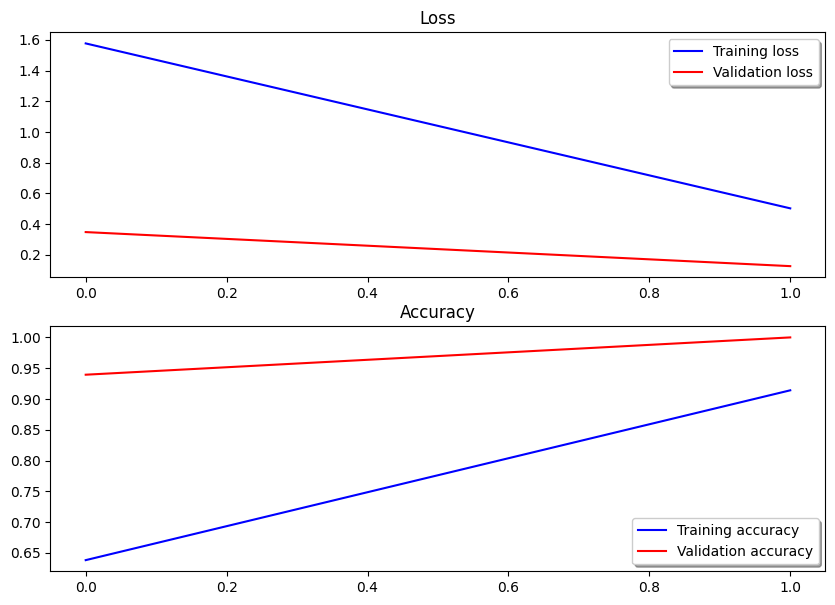

In [ ]:
#plotting loss and accuracy curve for training and validation set

fig, axes = plt.subplots(2, 1, figsize=(10, 7))

axes[0].plot(history.history['loss'], color='b', label='Training loss')
axes[0].plot(history.history['val_loss'], color='r', label='Validation loss')
legend = axes[0].legend(loc='best', shadow=True)
axes[0].set_title("Loss")

axes[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axes[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axes[1].set_title("Accuracy")
legend = axes[1].legend(loc='best', shadow=True)

In [ ]:
# path_to_save_arch = os.path.join(model_dir, "SLT_Recognition")
# print(path_to_save_arch)

/home/abhinav/Documents/Work/2 Hobby_projects/Models/SLT_Recognition


In [ ]:
# model.save(path_to_save_arch)

INFO:tensorflow:Assets written to: /home/abhinav/Documents/Work/2 Hobby_projects/Models/SLT_Recognition/assets


INFO:tensorflow:Assets written to: /home/abhinav/Documents/Work/2 Hobby_projects/Models/SLT_Recognition/assets


In [ ]:
from matplotlib.image import imread

from skimage.transform import resize

(60, 60, 3)
Shape of input:  (1, 60, 60, 3)
1/1 [==============================] - 0s 330ms/step
Shape of prediction:  (1, 35)
Shape of prediction values: (1,)
[11]
Actual predictions:
['C']


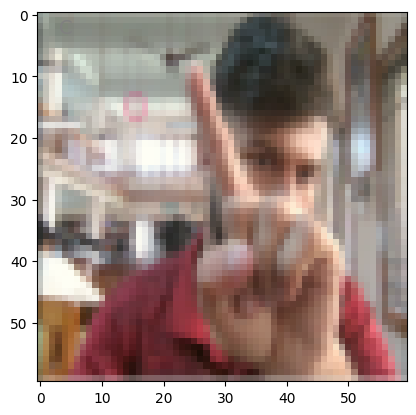

In [ ]:
# To check the model prediction for a single image


class_names = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", 
               "Q", "R", "S", "T", "U", "V", "W", "x", "Y", "z"]


img_path_t = "/home/abhinav/Pictures/Screenshots/q.jpg"


im = load_img(img_path_t)
im = np.array(im)
im = resize(im, [60, 60])
plt.imshow(im)

print(im.shape)
im = tf.expand_dims(im, 0)


print("Shape of input: ", im.shape)
prediction = model.predict(im)
print("Shape of prediction: ", prediction.shape)
prediction_values = np.argmax(prediction, axis=-1)
print("Shape of prediction values:", prediction_values.shape)
print(prediction_values)
print("Actual predictions:")
c = []
for i in prediction_values:
    c.append(class_names[i])
print(c)


plt.text(3, 3, c[0], color="gray", fontsize=14)
plt.show()


x_valid_shape:  (16, 60, 60, 3)
1/1 [==============================] - 0s 55ms/step
predict_x:  [[4.82826348e-04 1.60051291e-04 1.28459278e-03 2.90830212e-04
  3.45761422e-04 1.11287700e-04 1.56085094e-04 1.89371840e-05
  3.74126714e-04 1.30748202e-04 8.11934471e-04 3.68394365e-04
  2.48192257e-04 4.36156915e-05 1.32769215e-04 4.19296412e-04
  1.57100824e-03 4.20343786e-05 6.16801553e-05 5.14734362e-04
  6.06577923e-05 9.68583465e-01 1.52318394e-02 2.73014623e-04
  1.36665185e-03 5.90724172e-04 1.53915212e-03 8.59836407e-04
  9.38931364e-04 1.44210630e-04 2.30024802e-04 3.11741635e-04
  3.96993200e-05 1.86432723e-03 3.96797172e-04]
 [2.91525340e-03 1.14238157e-03 1.20532161e-04 4.08939493e-04
  1.14249336e-02 1.99352609e-04 3.23883170e-04 7.16265012e-03
  1.45215564e-03 5.66113449e-04 3.33684293e-04 1.69891544e-04
  4.59518080e-04 8.19811772e-04 1.01486163e-03 2.21276260e-03
  5.35039883e-03 6.54023373e-03 2.79671629e-04 1.85561716e-04
  9.49538887e-01 3.24563880e-04 6.54357718e-05 1.0

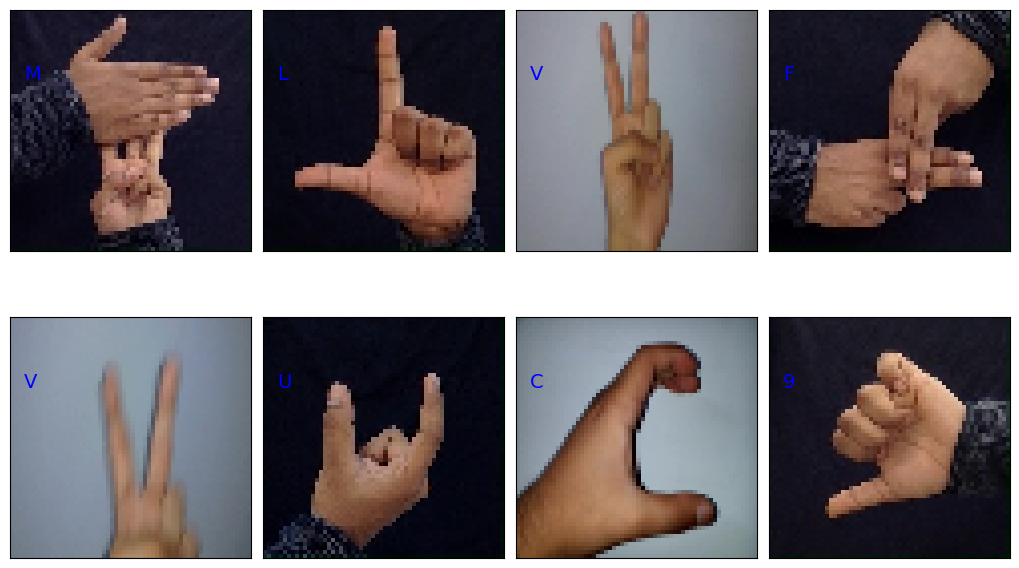

In [ ]:
#predictions

class_names = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", 
               "Q", "R", "S", "T", "U", "V", "W", "x", "Y", "z"]

x_valid, label_batch = next(iter(valid_generator))
# print("x_valid: ", x_valid)
# print("label_batch: ", label_batch)

print("x_valid_shape: ", x_valid.shape)

predict_x = model.predict(x_valid)
print("predict_x: ", predict_x)
prediction_values = np.argmax(predict_x,axis=1)
print("prediction_values", prediction_values)

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
    ax.imshow(x_valid[i, :], cmap=plt.cm.gray_r, interpolation='nearest')
    if prediction_values[i] == np.argmax(label_batch[i]):
        print("label_batch[i]: ", label_batch[i])
        print("prediction_values[i]:  is the same as np.argmax(label_batch[i])", prediction_values[i])
        print("class_names: ", class_names)
        ax.text(3, 17, class_names[prediction_values[i]], color='blue', fontsize=14)
    else:
        ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)

In [ ]:
results = model.evaluate(
    test_generator,
    verbose=2
)

print("Accuracy: ", results[1])
print("Loss: ", results[0])

33/33 - 1s - loss: 0.1285 - accuracy: 1.0000 - 644ms/epoch - 20ms/step
Accuracy:  1.0
Loss:  0.12846910953521729


In [ ]:
# Training set accuracy
# Accuracy ( AlexNet ) : 0.02 , Loss ( AlexNet ) : 3.69
# Accuracy ( MyNet ) : 80.1 , Loss ( MyNet ) : 0.63
# Accuracy ( LeNet ) : 1.00 , Loss ( LeNet ) : 0.01

# Validation set accuracy
# Accuracy ( AlexNet ) : 0.02 , Loss ( AlexNet ) : 3.69
# Accuracy ( MyNet ) : 96.0 , Loss ( MyNet ) : 0.83
# Accuracy ( LeNet ) : 1.00 , Loss ( LeNet ) : 0.01

# Test set accuracy
# Accuracy ( AlexNet ) : 0.02 , Loss ( AlexNet ) : 3.69
# Accuracy ( MyNet ) : 0.04 , Loss ( MyNet ) : 3.60
# Accuracy ( LeNet ) : 1.00 , Loss ( LeNet ) : 0.01
